Regress 'resale_price' on ['random_index', 'storey_range_lower', 'storey_range_upper', 'floor_area_sqm', 'year_when_new', 'resale_year_month', 'resale_calendar_month', 'STI_resale_date', 'CatE_COE_resale_date', 'block_number', 'postal_code', 'postal_code_2digit'] 

Random Forest regression may take time...

Each end node will have at least 6052 observations.

Randomly selected #24 of 100 trees in the Forest:


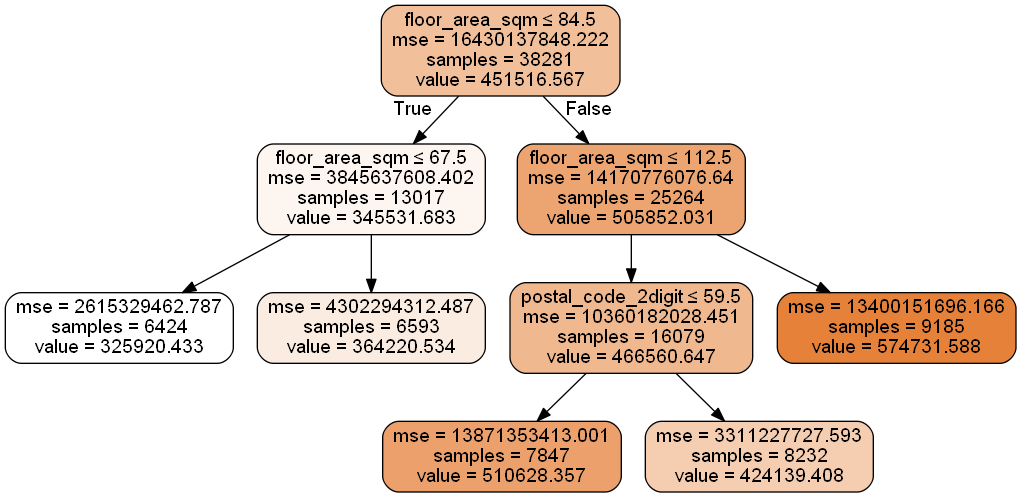

Coefficient-of-Determination of fit (could be better if tree display not needed) = 0.5127711764765991 


Refitting properly after displaying tree ...

Random forest validation  MAE = 17123.897644573804
Random forest validation RMSE = 24107.11345407295
Random forest validation   R² = 0.964222294303402


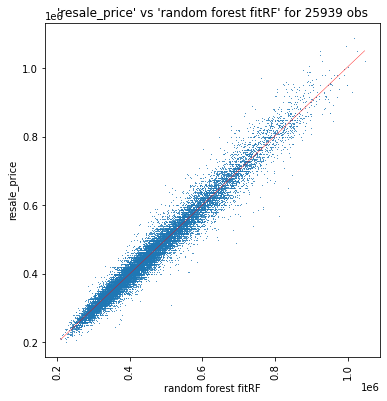


Random Forest regression for 60522 rows and 12 columns, and prediction for 25939 rows took 0.10 mins.


OLS with variable selection.

Full Model: resale_price ~ random_index + storey_range_lower + storey_range_upper + floor_area_sqm + year_when_new + resale_year_month + resale_calendar_month + STI_resale_date + CatE_COE_resale_date + block_number + postal_code + postal_code_2digit
Adj R² = 0.7650291130067781 

resale_price ~ random_index + storey_range_lower + storey_range_upper + floor_area_sqm + year_when_new + resale_year_month + resale_calendar_month + CatE_COE_resale_date + block_number + postal_code + postal_code_2digit
Adj R² = 0.7650326295134647 

resale_price ~ storey_range_lower + storey_range_upper + floor_area_sqm + year_when_new + resale_year_month + resale_calendar_month + CatE_COE_resale_date + block_number + postal_code + postal_code_2digit
Adj R² = 0.765035274470441 

resale_price ~ storey_range_lower + storey_range_upper + floor_area_sqm + year_when_new + resale_year

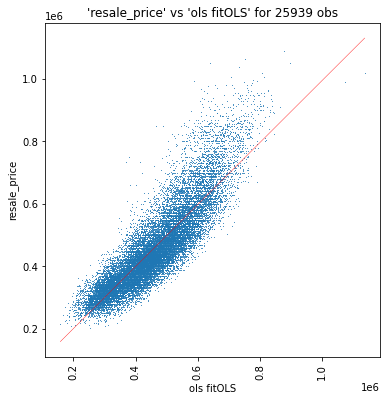


OLS variable selection for 60522 rows and 12 columns, and prediction for 25939 rows took 0.01 mins.


In [1]:
# Random Forest and OLS (with variable selection) Regressions

#https://data-flair.training/blogs/train-test-set-in-python-ml

import time
stm = time.time()
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
%matplotlib inline

import warnings 
warnings.filterwarnings('ignore')
#warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore')

import os
try:
    os.chdir(os.environ['USERPROFILE'] + '\Documents' + r"\0_Teach\data") #change "\0_Teach\data" accordingly
except:
    try:
        os.chdir('/Users/' + os.environ['USER'] + '/Documents' + r"/0_Teach/data") #for Mac
    except:
        #assume data file in current folder
        pass

#read data and delete non-numeric columns
   
d = pd.read_csv('HDB_Data.csv', index_col=0) #specifying 1st column as row labels (called 'index')
yname = 'resale_price'
# x = d.drop(['random_index','resale_price','town','flat_model','flat_type','block_letter','street_name','street_name_root',
#             'street_name_type','street_name_number','street_name_type_begin','no_of_rooms'], 1)

import re
d.rename(columns=lambda v: re.sub('\W', '_', v), inplace=True) #for ols latter
yname = re.sub('\W', '_', yname)

# x = d[set(d.columns) - set([yname])].select_dtypes(include='number').dropna(axis=1)
x = d.drop(yname, 1).select_dtypes(include='number').dropna(axis=1)
y = d[yname]

print("Regress '" + y.name + "' on", list(x),'\n')

#for speeding up intel cpu:
#https://github.com/intel/scikit-learn-intelex
#https://intel.github.io/scikit-learn-intelex
# !conda install scikit-learn-intelex --y
try:
#     from sklearnex import patch_sklearn
#     patch_sklearn()
    from importlib import import_module
    getattr(import_module('sklearnex'), 'patch_sklearn')()
except:
    pass
#to switch off intel extension, intelex:
# #sklearnex.unpatch_sklearn()
# getattr(import_module('sklearnex'), 'unpatch_sklearn')()

#split into training & testing sets

from sklearn.model_selection import train_test_split
#x_train,x_test,y_train,y_test = train_test_split(x, y, train_size=0.7, test_size=0.3, random_state=123)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)


#fit random forest model on training set

from sklearn.ensemble import RandomForestRegressor
print('Random Forest regression may take time...\n')
part = .1
model = RandomForestRegressor(n_jobs=-1, min_samples_leaf=part) #for displaying tree
model.fit(x_train, y_train)
xnames = list(x_train)

print('Each end node will have at least', int(len(x_train) * part), 'observations.\n')
import pydot
from IPython.display import Image
from sklearn import tree
rint = np.random.randint(len(model.estimators_))
print('Randomly selected #' + str(rint + 1), 'of', len(model.estimators_), 'trees in the Forest:')
display(Image(pydot.graph_from_dot_data(tree.export_graphviz(model.estimators_[rint],
                   feature_names=xnames, class_names=[str(a) for a in sorted(list(d[yname].unique()))],
                   filled=True, rounded=True, special_characters=True))[0].create_png()))
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.score
print('Coefficient-of-Determination of fit (could be better if tree display not needed) =', model.score(d[xnames], d[yname]), '\n')

print('\nRefitting properly after displaying tree ...\n')
model = RandomForestRegressor(n_jobs=-1).fit(x_train, y_train)

#predict using test set

fitRF = model.predict(x_test)
from sklearn.metrics import mean_absolute_error
print('Random forest validation  MAE =', mean_absolute_error(y_test, fitRF))
from sklearn.metrics import mean_squared_error
print('Random forest validation RMSE =', np.sqrt(mean_squared_error(y_test, fitRF)))
print('Random forest validation   R² =',
      pd.concat([y_test, pd.Series(fitRF, index=y_test.index)], 1).corr().iloc[0, 1] ** 2)

#plot y vs y-hat

pl.rcParams["figure.figsize"] = [6.000, 6.143] #square plot

#plot pseudo regression line
s, i = np.polyfit(fitRF, y_test, 1) #s=slope, i=intercept
a, b = min(fitRF), max(fitRF)
pl.plot([a, b], i + [s * a, s * b], 'red', linewidth=0.4) #increase linewidth for darker line
del s, i, a, b

#scatter y vs y-hat
pl.scatter(fitRF, y_test, s=1, linewidths=0)
xn = 'random forest fitRF'
yn = y_test.name
pl.xlabel(xn)
pl.ylabel(yn)
pl.xticks(rotation=90)
pl.title("'" + yn + "' vs '" + xn + "' for " + str(len(y_test)) + ' obs')
pl.show()

print('\nRandom Forest regression for', len(x_train), 'rows and', x_train.shape[1], 'columns, and prediction for',
      len(x_test), 'rows took', '%.2f' % ((time.time() - stm) / 60), 'mins.')


#ols variable selection

stm = time.time()
print('\n\nOLS with variable selection.')

df = pd.concat([y_train, x_train], axis=1)
import re
#model variable name must be alphanumeric and '_'
#any variable name character which is 'not alphanumeric or' '_' will be replaced by '_':
df.rename(columns=lambda x: re.sub('\W', '_', x), inplace=True)

#model number-1, i.e. best; keep updating this:
#m1 = mod; #wrong if rerun in cell
m1 = ' + '.join(list(df)).replace('+', '~', 1)
print('\nFull Model:', m1)

import statsmodels.formula.api as sm
out = sm.ols(m1, df).fit()

#r² number-1, i.e. best
#r1 = out.rsquared_adj; #wrong if rerun in cell
r1 = out.rsquared_adj
print('Adj R² =', r1, '\n')

xs = list(df) #list of x variables, keep updating this

while len(xs) > 2: #(y and last x) make 2 variables
    
    tabs = abs(out.tvalues[1:]) #omit intercept at position 1
    xs.remove(tabs[tabs == min(tabs)].index[0]) #remove name of variable with smallest |t|
    
    mod = ' + '.join(xs).replace('+', '~', 1) #rebuild model equation
    print(mod)
    
    out = sm.ols(mod, df).fit()
    radj = out.rsquared_adj
    print('Adj R² =', radj, '\n')
    
    if radj > r1: #found model with larger Adjusted R²
        r1 = radj #update best Adjusted R²
        m1 = mod #update best model equation
        
print('Best Model:', m1)
print('Best Adj R² =', r1, '\n')

fitOLS = sm.ols(m1, df).fit().predict(x_test)

#print(sm.ols(m1, df).fit().summary2())

print('OLS validation  MAE =', mean_absolute_error(y_test, fitOLS))
print('OLS validation RMSE =', np.sqrt(mean_squared_error(y_test, fitOLS)))
print('OLS validation   R² =', pd.concat([y_test, fitOLS], 1).corr().iloc[0, 1] ** 2)

#plot pseudo regression line
s, i = np.polyfit(fitOLS, y_test, 1) #s=slope, i=intercept
a, b = min(fitOLS), max(fitOLS)
pl.plot([a, b], i + [s * a, s * b], 'red', linewidth=0.4) #increase linewidth for darker line
del s, i, a, b

#scatter y vs y-hat
pl.scatter(fitOLS, y_test, s=1, linewidths=0)
xn = 'ols fitOLS'
yn = y_test.name
pl.xlabel(xn)
pl.ylabel(yn)
pl.xticks(rotation=90)
pl.title("'" + yn + "' vs '" + xn + "' for " + str(len(y_test)) + ' obs')
pl.show()

print('\nOLS variable selection for', len(x_train), 'rows and', x_train.shape[1], 'columns, and prediction for',
      len(x_test), 'rows took', '%.2f' % ((time.time() - stm) / 60), 'mins.')